In [11]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

In [12]:
conn = sqlite3.connect('data/checking-logs.sqlite')

In [13]:
checker = pd.read_sql_query('SELECT * FROM checker', conn)
deadlines = pd.read_sql_query('SELECT * FROM deadlines', conn)
pageviews = pd.read_sql_query('SELECT * FROM pageviews', conn)

In [14]:
checker['timestamp'] = pd.to_datetime(checker['timestamp'])
deadlines['deadlines'] = pd.to_datetime(deadlines['deadlines'], unit='s')

In [15]:
checker = checker.merge(deadlines, left_on='labname', right_on='labs', how='left')
checker['diff'] = (checker['timestamp'] - checker['deadlines']).dt.total_seconds() / 3600
checker_filtered = checker[(checker['labname'] != 'project1') & (checker['status'] == 'ready')]

In [16]:
if 'index' not in checker_filtered.columns:
    checker_filtered = checker_filtered.reset_index()

In [17]:
avg_diff = (
    checker_filtered.groupby('uid')['diff']
    .mean()
    .reset_index()
    .rename(columns={'diff': 'avg_diff'})
)

In [18]:
commits = (
    checker_filtered.groupby('uid')['index']
    .count()
    .reset_index()
    .rename(columns={'index': 'num_commits'})
)

In [19]:
pageviews_count = (
    pageviews.groupby('uid')['index']
    .count()
    .reset_index()
    .rename(columns={'index': 'pageviews'})
)

In [20]:
test_data = avg_diff.merge(commits, on='uid').merge(pageviews_count, on='uid')
ab_test = pd.read_csv('data/ab-test.csv')
test_users = ab_test[ab_test['group'] == 'test']['uid'].unique()
test_data_filtered = test_data[test_data['uid'].isin(test_users)]

array([[<Axes: xlabel='avg_diff', ylabel='avg_diff'>,
        <Axes: xlabel='pageviews', ylabel='avg_diff'>,
        <Axes: xlabel='num_commits', ylabel='avg_diff'>],
       [<Axes: xlabel='avg_diff', ylabel='pageviews'>,
        <Axes: xlabel='pageviews', ylabel='pageviews'>,
        <Axes: xlabel='num_commits', ylabel='pageviews'>],
       [<Axes: xlabel='avg_diff', ylabel='num_commits'>,
        <Axes: xlabel='pageviews', ylabel='num_commits'>,
        <Axes: xlabel='num_commits', ylabel='num_commits'>]], dtype=object)

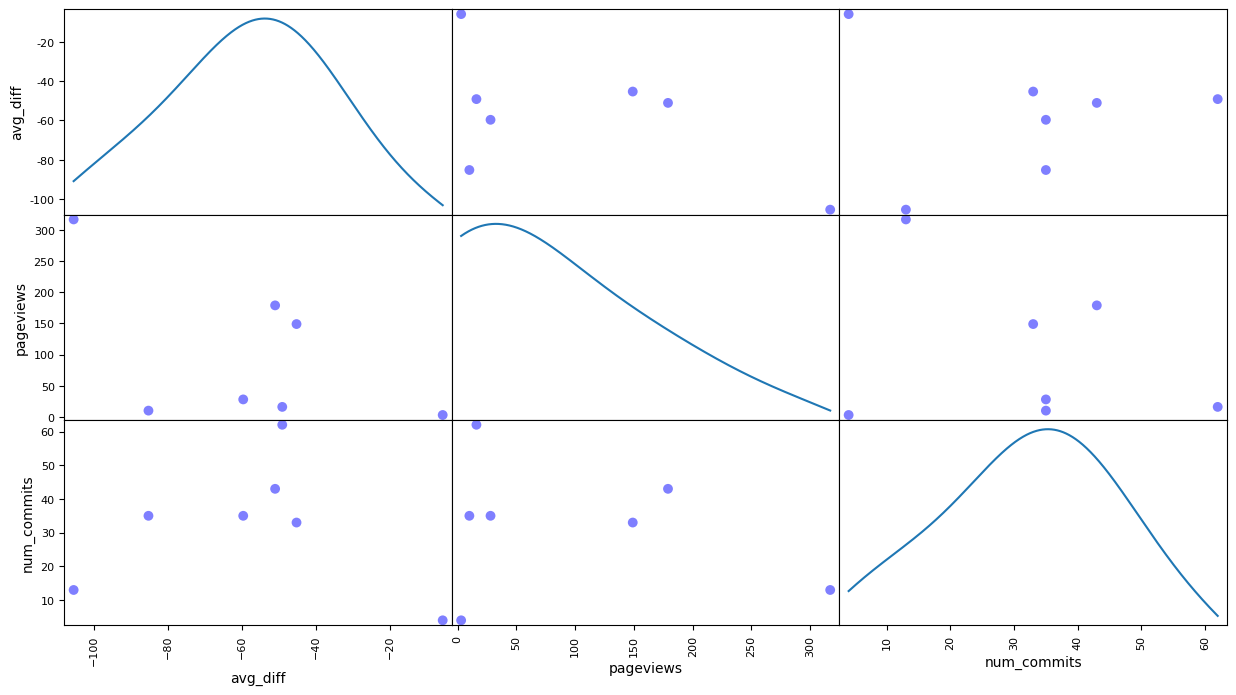

In [21]:
scatter_matrix(
    test_data_filtered[['avg_diff','pageviews', 'num_commits']],
    figsize=(15, 8),
    s=200,
    diagonal='kde',
    linewidth=3,
    color='blue'
)

In [22]:
conn.close()

Можно ли сказать, что если у пользователя мало просмотров страниц, то, скорее всего, у него мало и коммитов?

In [23]:
correlation_pageviews_commits = test_data['pageviews'].corr(test_data['num_commits'])
q1 = 'да' if abs(correlation_pageviews_commits) >= 0.2 else 'нет'
print(f'Ответ: {q1}')

Ответ: нет


Можем ли мы сказать, что если у пользователя мало просмотров страниц, то, скорее всего, у него небольшая средняя разница между первым коммитом и крайним сроком выполнения лабораторных работ?

In [24]:
correlation_pageviews_diff = test_data['pageviews'].corr(test_data['avg_diff'])
q2 = 'да' if correlation_pageviews_diff <= -0.2 else 'нет'
print(f'Ответ: {q2}')

Ответ: да


Можем ли мы сказать, что есть много пользователей с малым количеством коммитов и несколько с большим количеством коммитов?

In [25]:
commits_distribution = test_data['num_commits'].describe()
q3 = 'да' if commits_distribution['std'] > 0.5 * commits_distribution['mean'] else 'нет'
print(f'Ответ: {q3}')

Ответ: да


Можно ли сказать, что есть много пользователей с небольшой средней разницей и несколько с большой средней разницей?

In [26]:
diff_distribution = test_data['avg_diff'].describe()
q4 = 'да' if diff_distribution['std'] > 0.5 * abs(diff_distribution['mean']) else 'нет'
print(f'Ответ: {q4}')

Ответ: да
